In [77]:
# https://github.com/SamQLuong/Lorenz-System-with-Neural-Networks

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [78]:
# Generate Lorenz time series data
def generate_lorenz_data(length, rho):
    sigma, beta = 10, 8/3
    dt = 0.01
    x, y, z = [0.1], [0], [0]
    for _ in range(length-1):
        x.append(x[-1] + sigma * (y[-1] - x[-1]) * dt)
        y.append(y[-1] + (x[-1] * (rho - z[-1]) - y[-1]) * dt)
        z.append(z[-1] + (x[-1] * y[-1] - beta * z[-1]) * dt)
    return torch.tensor(x).reshape(-1, 1).float()

data_length = 1000

train_data_rho10 = generate_lorenz_data(data_length, 10)
train_data_rho28 = generate_lorenz_data(data_length, 28)
train_data_rho40 = generate_lorenz_data(data_length, 40)
test_data_rho17 = generate_lorenz_data(data_length, 17)
test_data_rho35 = generate_lorenz_data(data_length, 35)

# Combine training datasets with different rho values
train_data = torch.cat((train_data_rho10, train_data_rho28, train_data_rho40), dim=0)
test_data = torch.cat((test_data_rho17, test_data_rho35), dim=0)


# Create data loaders
train_dataset = TensorDataset(train_data[:-1], train_data[1:])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_data[:-1], test_data[1:])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
# Define the neural network model
class ForecastNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Initialize the model and loss function
model = ForecastNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch [1/100],Train Loss: 35.3223, Test Loss: 6.1450
Epoch [2/100],Train Loss: 2.6384, Test Loss: 0.3268
Epoch [3/100],Train Loss: 0.2923, Test Loss: 0.2082
Epoch [4/100],Train Loss: 0.2507, Test Loss: 0.2059
Epoch [5/100],Train Loss: 0.2473, Test Loss: 0.2045
Epoch [6/100],Train Loss: 0.2438, Test Loss: 0.2037
Epoch [7/100],Train Loss: 0.2408, Test Loss: 0.2015
Epoch [8/100],Train Loss: 0.2380, Test Loss: 0.2006
Epoch [9/100],Train Loss: 0.2350, Test Loss: 0.2013
Epoch [10/100],Train Loss: 0.2340, Test Loss: 0.1995
Epoch [11/100],Train Loss: 0.2319, Test Loss: 0.1980
Epoch [12/100],Train Loss: 0.2307, Test Loss: 0.1970
Epoch [13/100],Train Loss: 0.2295, Test Loss: 0.1970
Epoch [14/100],Train Loss: 0.2281, Test Loss: 0.1986
Epoch [15/100],Train Loss: 0.2277, Test Loss: 0.1982
Epoch [16/100],Train Loss: 0.2281, Test Loss: 0.1965
Epoch [17/100],Train Loss: 0.2274, Test Loss: 0.1993
Epoch [18/100],Train Loss: 0.2266, Test Loss: 0.1982
Epoch [19/100],Train Loss: 0.2268, Test Loss: 0.1953
E

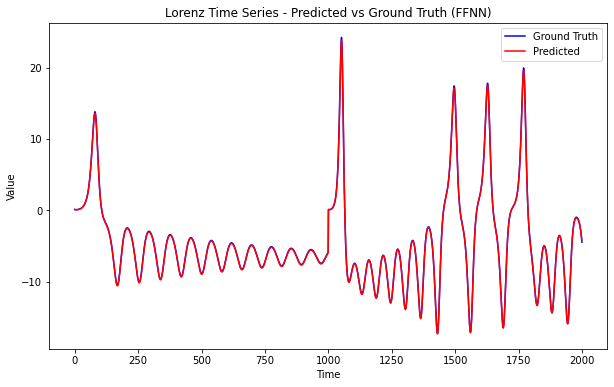

In [80]:
# Set model to evaluation mode
model.eval()

# Initialize a list to store the predicted time series
predicted_data = []

# Iterate over the test dataset and generate predictions
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predicted_data.append(outputs.detach().numpy())

# Concatenate and reshape the predicted data
predicted_data = np.concatenate(predicted_data).reshape(-1)

# Plot the predicted and ground truth time series
plt.figure(figsize=(10, 6))
plt.plot(test_data.numpy(), label='Ground Truth', color='blue')
plt.plot(predicted_data, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz Time Series - Predicted vs Ground Truth (FFNN)')
plt.legend()
plt.show()

In [81]:
# Define the LSTM model
class ForecastLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n.squeeze(0))
        return x

# Define hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Initialize the model and loss function
modelLSTM = ForecastLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(modelLSTM.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    modelLSTM.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = modelLSTM(inputs.unsqueeze(2))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    modelLSTM.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = modelLSTM(inputs.unsqueeze(2))
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)
        
    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch [1/100],Train Loss: 58.7037, Test Loss: 49.9222
Epoch [2/100],Train Loss: 46.7205, Test Loss: 35.2001
Epoch [3/100],Train Loss: 33.6814, Test Loss: 22.4625
Epoch [4/100],Train Loss: 23.5347, Test Loss: 15.2373
Epoch [5/100],Train Loss: 16.8811, Test Loss: 11.5165
Epoch [6/100],Train Loss: 12.8232, Test Loss: 9.5548
Epoch [7/100],Train Loss: 10.5614, Test Loss: 8.5450
Epoch [8/100],Train Loss: 9.3065, Test Loss: 7.8764
Epoch [9/100],Train Loss: 8.4269, Test Loss: 7.2183
Epoch [10/100],Train Loss: 7.6301, Test Loss: 6.4268
Epoch [11/100],Train Loss: 6.7635, Test Loss: 5.4664
Epoch [12/100],Train Loss: 5.9554, Test Loss: 4.6678
Epoch [13/100],Train Loss: 5.2422, Test Loss: 3.9875
Epoch [14/100],Train Loss: 4.6113, Test Loss: 3.4079
Epoch [15/100],Train Loss: 4.0422, Test Loss: 2.8906
Epoch [16/100],Train Loss: 3.5239, Test Loss: 2.4585
Epoch [17/100],Train Loss: 3.0519, Test Loss: 2.0943
Epoch [18/100],Train Loss: 2.6576, Test Loss: 1.7930
Epoch [19/100],Train Loss: 2.3426, Test Los

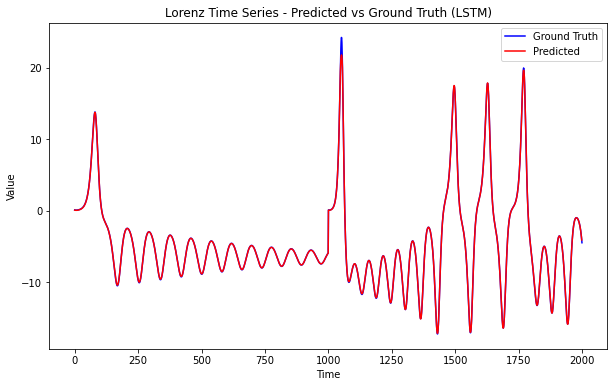

In [82]:
# Set model to evaluation mode
modelLSTM.eval()

# Initialize a list to store the predicted time series
predicted_data = []

# Iterate over the test dataset and generate predictions
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = modelLSTM(inputs.unsqueeze(2))
        predicted_data.append(outputs.detach().numpy())

# Concatenate and reshape the predicted data
predicted_data = np.concatenate(predicted_data).reshape(-1)

# Plot the predicted and ground truth time series
plt.figure(figsize=(10, 6))
plt.plot(test_data.numpy(), label='Ground Truth', color='blue')
plt.plot(predicted_data, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz Time Series - Predicted vs Ground Truth (LSTM)')
plt.legend()
plt.show()

In [83]:
# Define the RNN model
class ForecastRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h_n = self.rnn(x)
        x = self.fc(h_n.squeeze(0))
        return x

# Define hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Initialize the model and loss function
modelRNN = ForecastRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(modelRNN.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    modelRNN.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = modelRNN(inputs.unsqueeze(2))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    modelRNN.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = modelRNN(inputs.unsqueeze(2))
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch [1/100],Train Loss: 46.4062, Test Loss: 30.3624
Epoch [2/100],Train Loss: 22.6867, Test Loss: 12.5069
Epoch [3/100],Train Loss: 9.6921, Test Loss: 5.8488
Epoch [4/100],Train Loss: 5.7987, Test Loss: 4.7899
Epoch [5/100],Train Loss: 4.8756, Test Loss: 4.3750
Epoch [6/100],Train Loss: 4.3392, Test Loss: 3.7452
Epoch [7/100],Train Loss: 3.8036, Test Loss: 3.1855
Epoch [8/100],Train Loss: 3.3024, Test Loss: 2.6192
Epoch [9/100],Train Loss: 2.8676, Test Loss: 2.2784
Epoch [10/100],Train Loss: 2.5049, Test Loss: 1.9502
Epoch [11/100],Train Loss: 2.2098, Test Loss: 1.7173
Epoch [12/100],Train Loss: 1.9626, Test Loss: 1.5203
Epoch [13/100],Train Loss: 1.7576, Test Loss: 1.3671
Epoch [14/100],Train Loss: 1.5874, Test Loss: 1.2221
Epoch [15/100],Train Loss: 1.4372, Test Loss: 1.1029
Epoch [16/100],Train Loss: 1.3082, Test Loss: 0.9872
Epoch [17/100],Train Loss: 1.1951, Test Loss: 0.8980
Epoch [18/100],Train Loss: 1.0924, Test Loss: 0.8290
Epoch [19/100],Train Loss: 1.0000, Test Loss: 0.748

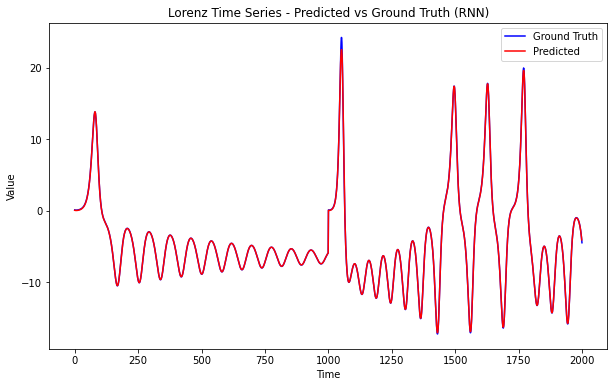

In [84]:
# Set model to evaluation mode
modelRNN.eval()

# Initialize a list to store the predicted time series
predicted_data = []

# Iterate over the test dataset and generate predictions
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = modelRNN(inputs.unsqueeze(2))
        predicted_data.append(outputs.detach().numpy())

# Concatenate and reshape the predicted data
predicted_data = np.concatenate(predicted_data).reshape(-1)

# Plot the predicted and ground truth time series
plt.figure(figsize=(10, 6))
plt.plot(test_data.numpy(), label='Ground Truth', color='blue')
plt.plot(predicted_data, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz Time Series - Predicted vs Ground Truth (RNN)')
plt.legend()
plt.show()

In [85]:
# Define the Echo State Network model
class ESN(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9):
        super(ESN, self).__init__()
        self.reservoir = nn.Linear(reservoir_size, reservoir_size, bias=False)
        self.input_weights = nn.Linear(input_size, reservoir_size, bias=False)
        self.output = nn.Linear(reservoir_size, output_size)
        self.activation = nn.Tanh()
        self.spectral_radius = spectral_radius

    def forward(self, x):
        x = self.input_weights(x)
        reservoir_states = torch.zeros(x.size(0), self.reservoir.weight.size(1)).to(x.device)
        for t in range(x.size(1)):
            reservoir_states = self.activation(x[:, t, :] + torch.matmul(reservoir_states, self.reservoir.weight.t()))
        output = self.output(reservoir_states)
        return output

# Define hyperparameters
input_size = 1
reservoir_size = 100
output_size = 1
spectral_radius = 0.9
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Initialize the model and loss function
modelESN = ESN(input_size, reservoir_size, output_size, spectral_radius)
criterion = nn.MSELoss()
optimizer = optim.Adam(modelESN.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    modelESN.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = modelESN(inputs.unsqueeze(2))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    modelESN.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = modelESN(inputs.unsqueeze(2))
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/100],Train Loss: 40.3685, Test Loss: 21.1252
Epoch [2/100],Train Loss: 15.7758, Test Loss: 10.7507
Epoch [3/100],Train Loss: 10.9458, Test Loss: 9.1201
Epoch [4/100],Train Loss: 9.6879, Test Loss: 8.0433
Epoch [5/100],Train Loss: 8.4950, Test Loss: 7.0205
Epoch [6/100],Train Loss: 7.4187, Test Loss: 6.1133
Epoch [7/100],Train Loss: 6.4101, Test Loss: 5.1888
Epoch [8/100],Train Loss: 5.3792, Test Loss: 4.2471
Epoch [9/100],Train Loss: 4.3975, Test Loss: 3.4362
Epoch [10/100],Train Loss: 3.5533, Test Loss: 2.6733
Epoch [11/100],Train Loss: 2.8521, Test Loss: 2.1576
Epoch [12/100],Train Loss: 2.3784, Test Loss: 1.7892
Epoch [13/100],Train Loss: 2.0497, Test Loss: 1.5791
Epoch [14/100],Train Loss: 1.8268, Test Loss: 1.4263
Epoch [15/100],Train Loss: 1.6567, Test Loss: 1.2861
Epoch [16/100],Train Loss: 1.5145, Test Loss: 1.1897
Epoch [17/100],Train Loss: 1.3974, Test Loss: 1.0829
Epoch [18/100],Train Loss: 1.2964, Test Loss: 1.0285
Epoch [19/100],Train Loss: 1.2044, Test Loss: 0.93

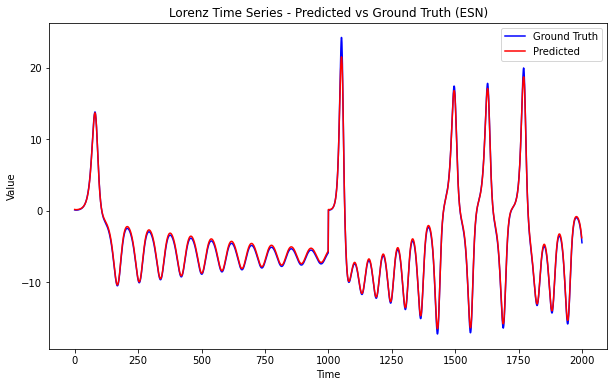

In [86]:
# Set model to evaluation mode
modelESN.eval()

# Initialize a list to store the predicted time series
predicted_data = []

# Iterate over the test dataset and generate predictions
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = modelESN(inputs.unsqueeze(2))
        predicted_data.append(outputs.detach().numpy())

# Concatenate and reshape the predicted data
predicted_data = np.concatenate(predicted_data).reshape(-1)

# Plot the predicted and ground truth time series
plt.figure(figsize=(10, 6))
plt.plot(test_data.numpy(), label='Ground Truth', color='blue')
plt.plot(predicted_data, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz Time Series - Predicted vs Ground Truth (ESN)')
plt.legend()
plt.show()